### An example of the SIGW inverse problem with the full numerical integration 

In [6]:
import sys
sys.path.append('../')
from jax import vmap, jit, grad, random, jacfwd
from jax.lax import map
import jax.numpy as jnp
import numpy as np
import time
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import warnings
from jax import config
config.update("jax_enable_x64", True)
import numpyro
from interpolation.omega_gw_jax import OmegaGWjax
from interpolation.model import Fixed_Nodes_Model, Free_Nodes_Model, spline_predict
from getdist import plots,MCSamples,loadMCSamples
%config InlineBackend.figure_format = 'retina'
font = {'size'   : 16, 'family':'serif'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True) # if using latex in plots
matplotlib.rc('legend', fontsize=16)


#### A simple test curvature power spectrum and $\Omega_{\rm GW}$

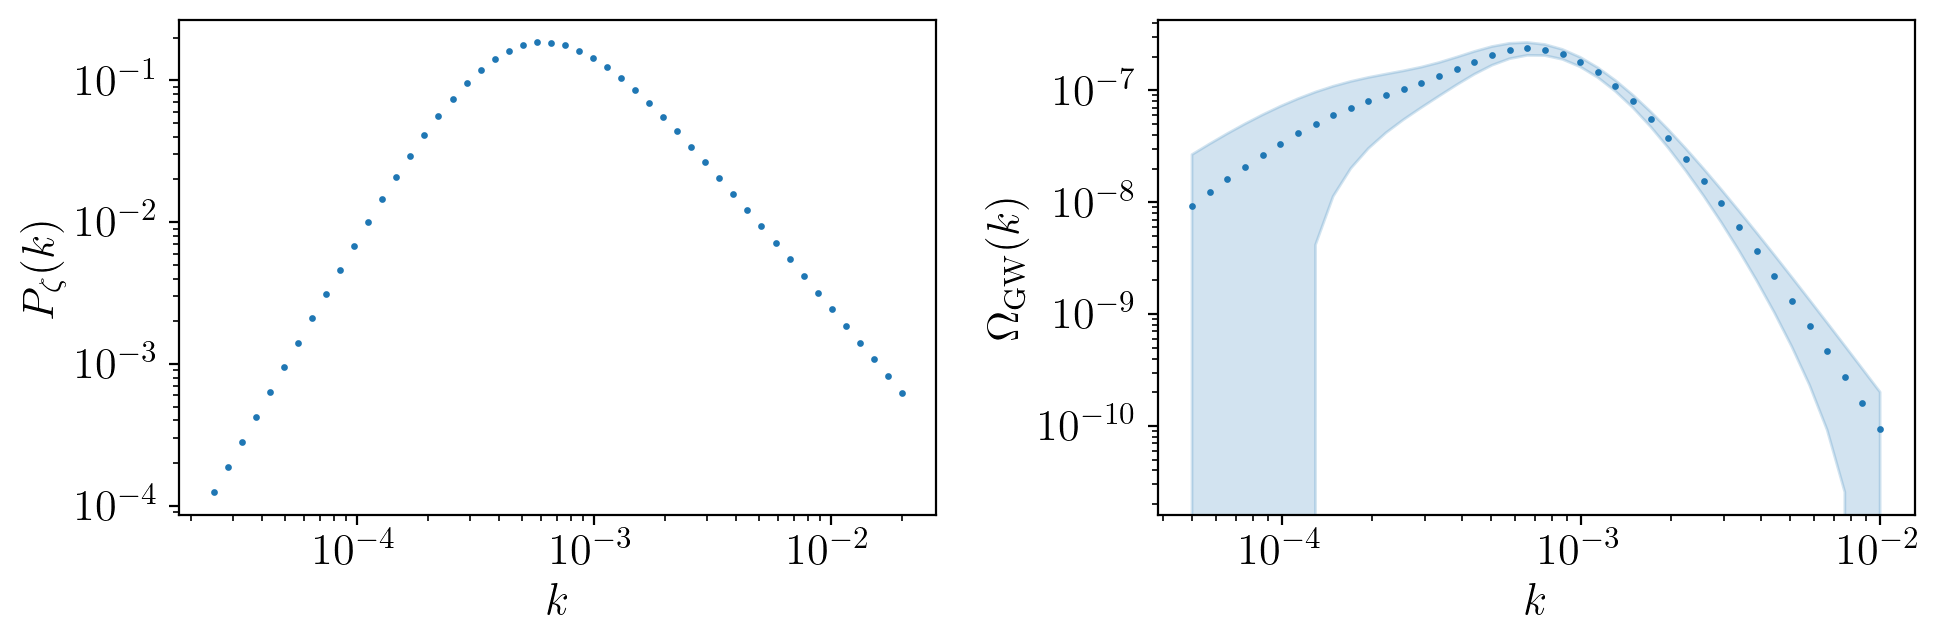

In [7]:
# set up the power spectrum and omgw
psize = 50
ksize = 40
k_arr = jnp.geomspace(5e-5,1e-2,ksize)
p_arr = jnp.geomspace(min(k_arr)/2,max(k_arr)*2,psize)

f = k_arr #jnp.geomspace(5e-5, 1e-2, ksize)  # The frequencies to calculate Omega_GW
s = jnp.linspace(0, 1, 10)  # First rescaled internal momentum
t = jnp.logspace(-3,3, 100)  # Second rescaled internal momentum

## Expand t to add a new axis
t_expanded = jnp.expand_dims(t, axis=-1)
## Repeat t along the new axis to match the shape (100, 1000)
t = jnp.repeat(t_expanded, len(f), axis=-1)

@jit
def pz(p,pstar=5e-4,n1=3,n2=-2,sigma=2):
    nir = n1
    pl1 = (p/pstar)**nir
    nuv = (n2 - n1)/sigma
    pl2 = (1+(p/pstar)**sigma)**nuv
    # osc = (1 + 16.4*jnp.cos(1.4*jnp.log(p/1.))**2)
    return pl1 * pl2 #*osc

gwb_calculator =  OmegaGWjax(s, t, f=f, kernel="RD", upsample=False)


pz_amp = pz(p_arr)
gwb_amp = gwb_calculator(pz,f)
kstar = 1e-3
omks_sigma = gwb_amp*( 0.1*(np.log(k_arr/kstar))**2 + 0.05) # 2% error at kstar + more towards edges
gwb_cov = jnp.diag(omks_sigma**2)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,3.5))
ax1.scatter(p_arr,pz_amp,s=2)
ax1.set_ylabel(r'$P_{\zeta}(k)$')
ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}(k)$')
ax2.scatter(f,gwb_amp,s=2)
ax2.fill_between(k_arr,gwb_amp+1.96*omks_sigma,gwb_amp-1.96*omks_sigma,alpha=0.2,color='C0')
for ax in [ax1,ax2]:
    ax.set(yscale='log',xscale='log',xlabel=r'$k$')
fig.tight_layout();

In [21]:
# Set up the fixed node interpolator
kmin, kmax = min(p_arr), max(p_arr)
gwb_method_kwargs = {'s': s, 't': t}
pz_model = Fixed_Nodes_Model(n_nodes=5,pz_kmin=kmin,pz_kmax=kmax,
                            gwb_karr=k_arr,gwb_means=gwb_amp,
                            gwb_cov=gwb_cov,gwb_method='jax',gwb_method_kwargs=gwb_method_kwargs,y_low=-5,y_high=1)

In [22]:
# run the HMC
samples, extras = pz_model.run_hmc_inference(num_warmup=512,num_samples=512,seed=0)

sample: 100%|██████████| 1024/1024 [02:54<00:00,  5.86it/s, 15 steps of size 1.64e-01. acc. prob=0.98]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      y[0]     -2.86      1.26     -3.40     -4.34     -1.07      8.42      1.01
      y[1]     -1.80      0.89     -1.50     -3.92     -1.29      8.95      1.15
      y[2]     -0.90      0.43     -0.77     -1.29     -0.66     10.40      1.11
      y[3]     -1.87      0.12     -1.90     -1.95     -1.58     17.98      1.02
      y[4]     -4.70      0.46     -4.91     -4.97     -3.87      4.66      1.35

Number of divergences: 29


#### Now we plot some realisations of the inferred $P_{\zeta}$ from the MCMC samples

(16, 50)


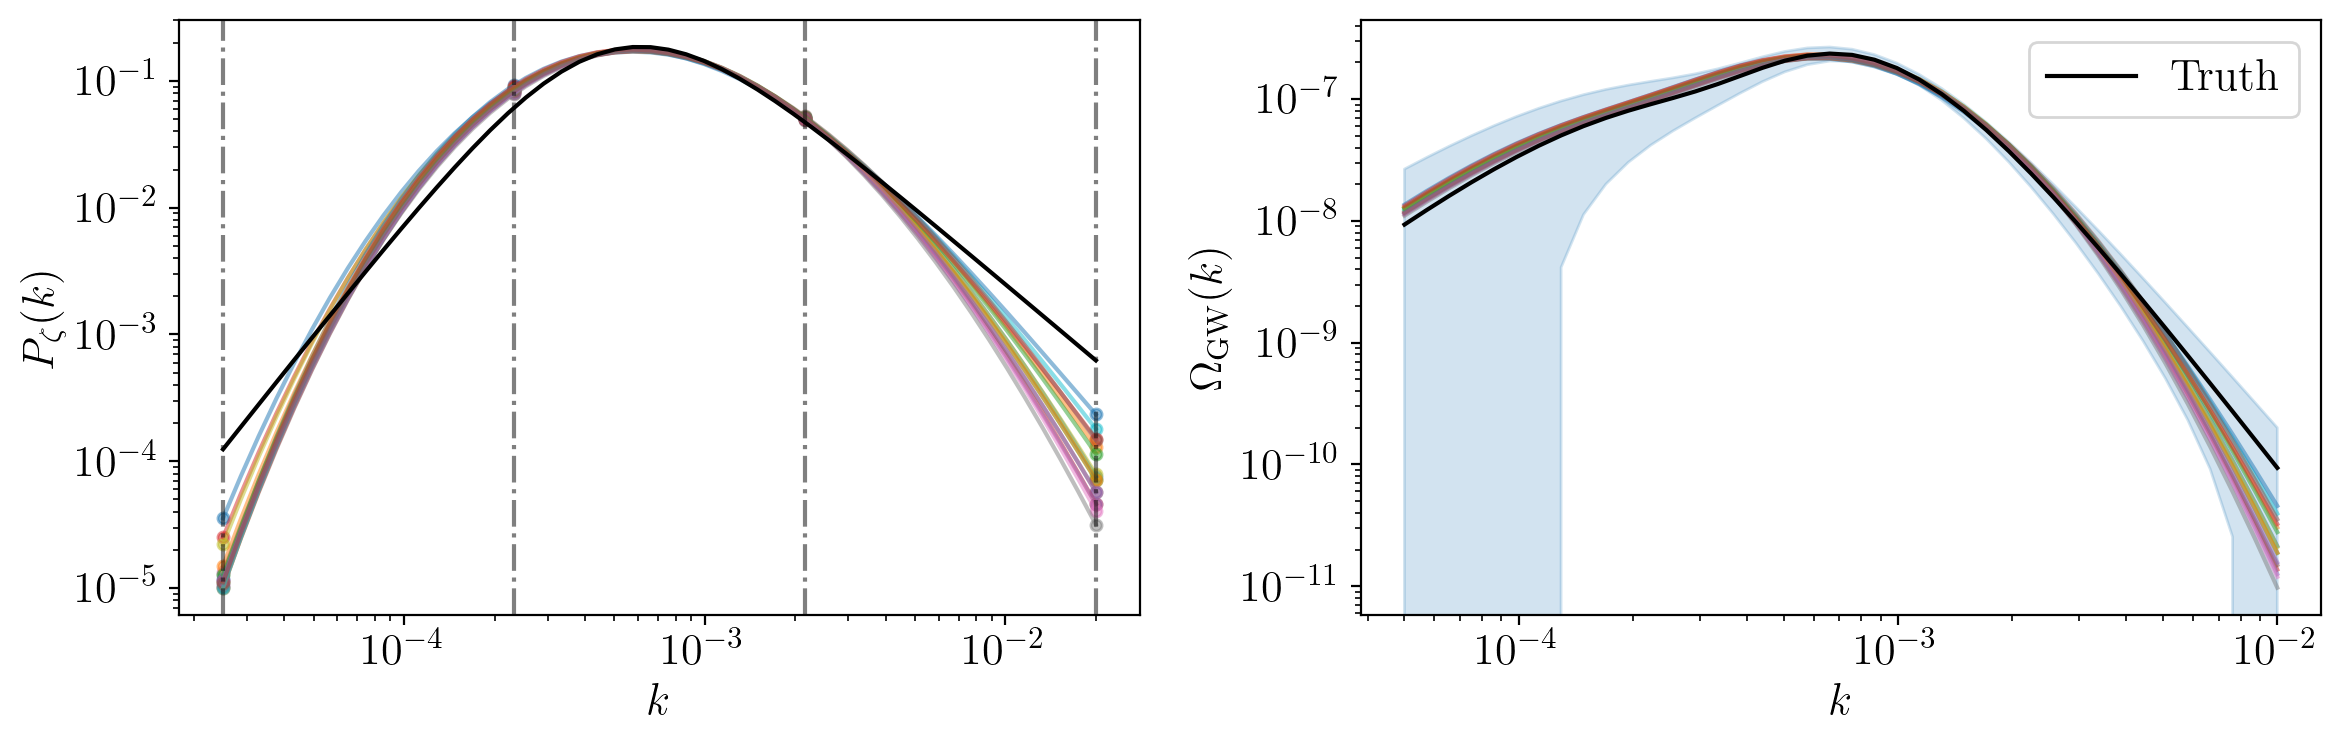

In [10]:
nodes = pz_model.log_k_nodes
ys = samples['y'][::32] #jnp.median(samples['y'])
ff = lambda y: spline_predict(x_train=nodes,y_train=y,x_pred=f)

def omega_f(y):
    res = pz_model.get_gwb_from_xy(x=nodes,y=y)
    return res
gwb_amps = map(omega_f,ys)

ff = lambda y: spline_predict(x_train=nodes,y_train=y,x_pred=p_arr)
pz_amps = vmap(ff,)(ys)
print(pz_amps.shape)
# gwb_amps = jnp.einsum("pi,pj,kij->pk",pz_amps,pz_amps,gwb_calculator.omkij)
# print(gwb_amps.shape)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

for i,pz in enumerate(pz_amps):
    ax1.loglog(p_arr,pz,alpha=0.5)
    ax1.scatter(10**(nodes),10**(ys[i]),s=16,alpha=0.5)
for om in gwb_amps:
    ax2.loglog(k_arr,om,alpha=0.5)
ax1.loglog(p_arr,pz_amp,color='k',lw=1.5)
ax2.plot(k_arr,gwb_amp,color='k',lw=1.5,label='Truth')
ax2.fill_between(k_arr,gwb_amp+1.96*omks_sigma,gwb_amp-1.96*omks_sigma,alpha=0.2,color='C0')
ax2.set(yscale='log',xscale='log')
                                                                                                                                                                                                       
ax1.set_ylabel(r'$P_{\zeta}(k)$')
ax1.set_xlabel(r'$k$')
# ax2.set_ylim(1e-11,1e-6)

ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}(k)$')
ax2.set_xlabel(r'$k$')
ax2.legend()
for val in nodes:
    ax1.axvline(10**(val),color='k',ls='-.',alpha=0.5)
fig.tight_layout()
# the dashed lines represent the spline node locations

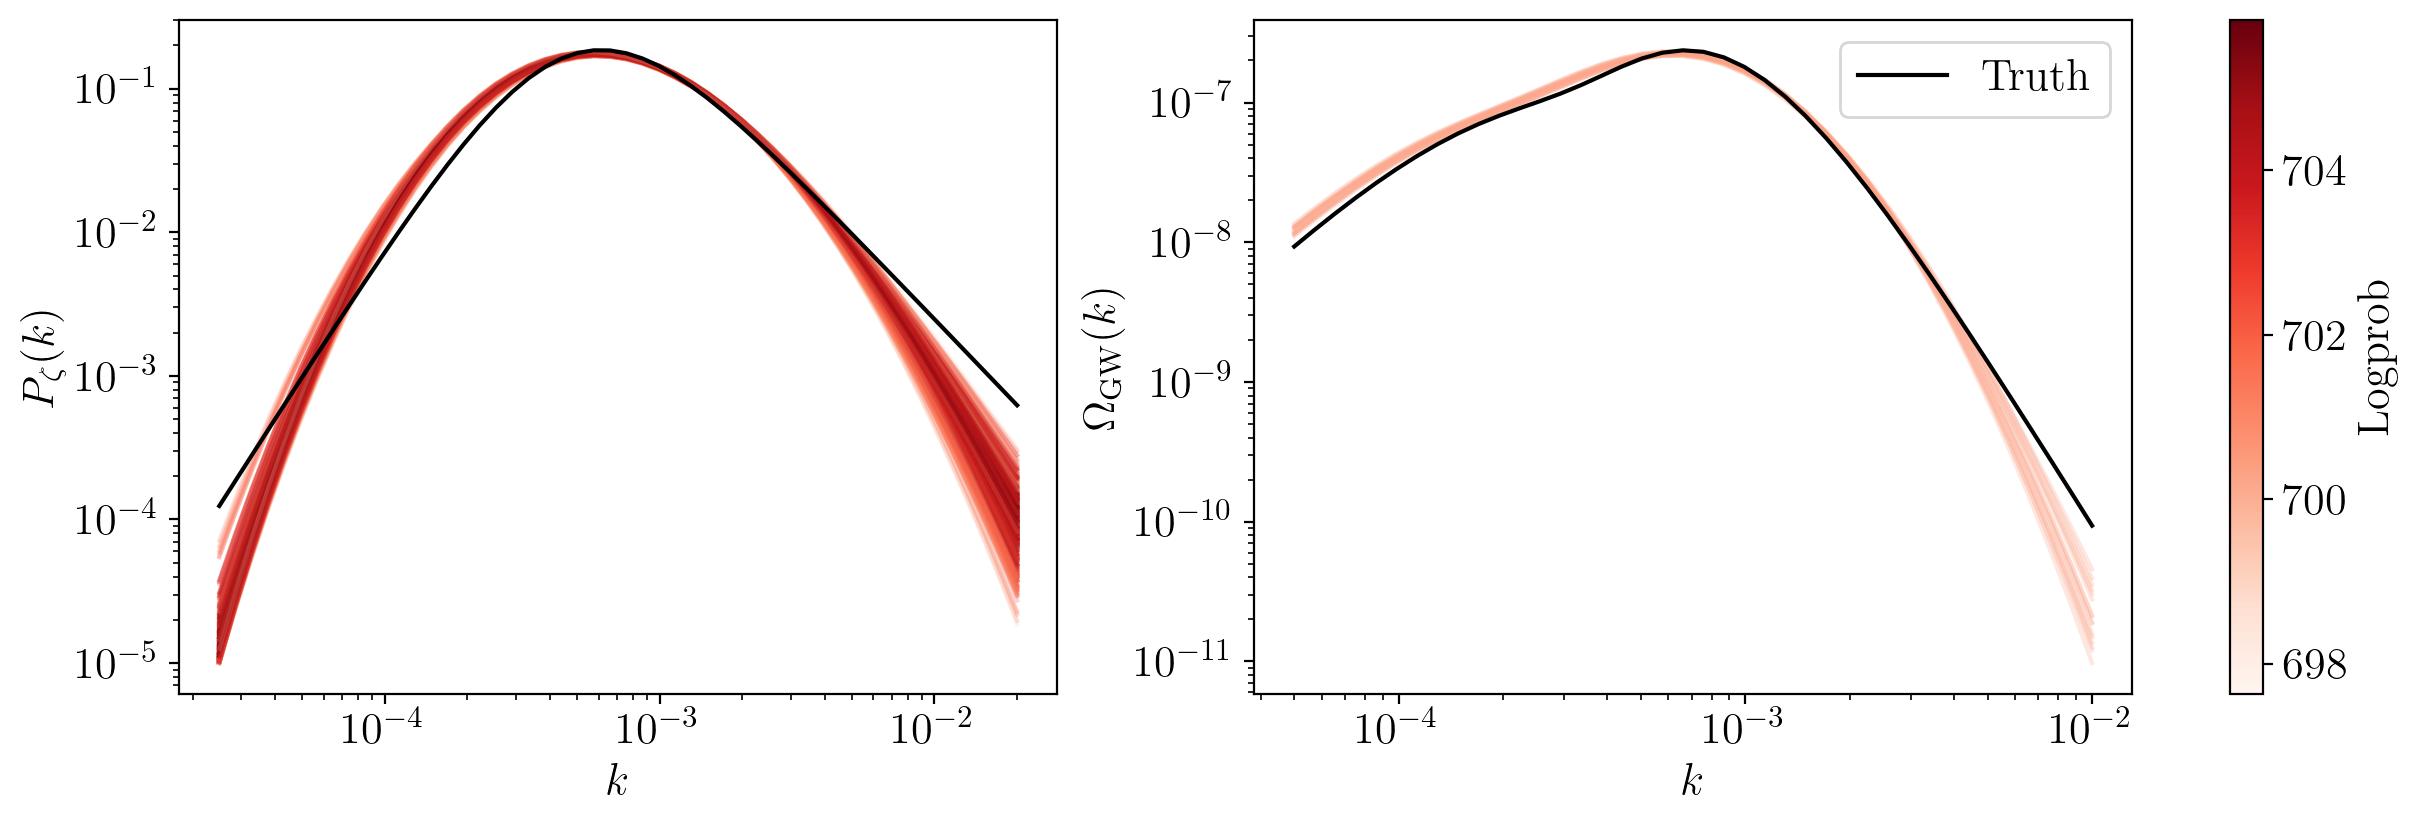

In [11]:
### Plot the MC realisations with their logprob
cmap = matplotlib.colormaps['Reds']
ys = samples['y']
lp = -extras["potential_energy"] # PE = -negative logprob
lp_min, lp_max = np.min(lp), np.max(lp)
cols = (lp-lp_min)/(lp_max - lp_min) # normalise the logprob to a colour
norm = colors.Normalize(lp_min,lp_max)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4),layout='constrained')
pz_amps = vmap(ff,)(ys)
for i,pz in enumerate(pz_amps):
    ax1.loglog(p_arr,pz,alpha=0.25,color=cmap(cols[i]))
    # ax1.scatter(10**(nodes),10**(ys[i]),s=16,alpha=0.5)
for om in gwb_amps:
    ax2.loglog(k_arr,om,alpha=0.25,color=cmap(cols[i]))
ax1.loglog(p_arr,pz_amp,color='k',lw=1.5)
ax2.loglog(k_arr,gwb_amp,color='k',lw=1.5,label='Truth')

ax2.legend()
ax1.set_ylabel(r'$P_{\zeta}(k)$')
ax1.set_xlabel(r'$k$')
# ax2.set_ylim(1e-11,1e-6)

ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}(k)$')
ax2.set_xlabel(r'$k$')
fig.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap),ax=[ax1,ax2],label='Logprob')
# fig.subplots_adjust(hspace=0.3)
# fig.tight_layout()

#### Do an optimization instead of HMC sampling

In [12]:
from interpolation.model import optim_scipy_bh , optim_optax
nodes = pz_model.log_k_nodes
best_idx = jnp.argmin(extras['potential_energy'])
worst_idx = jnp.argmax(extras['potential_energy'])
print(samples['y'][worst_idx])
x0 = samples['y'][best_idx]  
print(x0)
# x0 = -1.5*jnp.ones(5)
# best_params, _ = optim_scipy_bh(x0 = x0,loss = pz_model.loss,bounds=len(x0)*[(-7,1)],stepsize=0.2,niter=20) 
best_params, _ =  optim_optax(x0 = x0, loss = pz_model.loss, start_learning_rate=0.3 , steps = 100, jump_sdev=1.,y_low=-7.,y_high=1.)
print(best_params)
pz_bf = lambda x: spline_predict(x_train=nodes,y_train=best_params,x_pred=x)
# gwb_calculator =  OmegaGWjax(s, t, f=f, kernel="RD", upsample=False)
gwb_bf = pz_model.get_gwb_from_xy(x=nodes,y=best_params) #gwb_calculator(pz_bf,f) #jnp.einsum("i,j,kij->k",pz_bf,pz_bf,gwb_calculator.omkij)

[-4.99998419 -1.07353516 -1.29590723 -4.04624368]
[-4.88265779 -1.07069269 -1.29222194 -4.05078903]
[-7.         -1.15834917 -1.31030008 -3.133211  ]


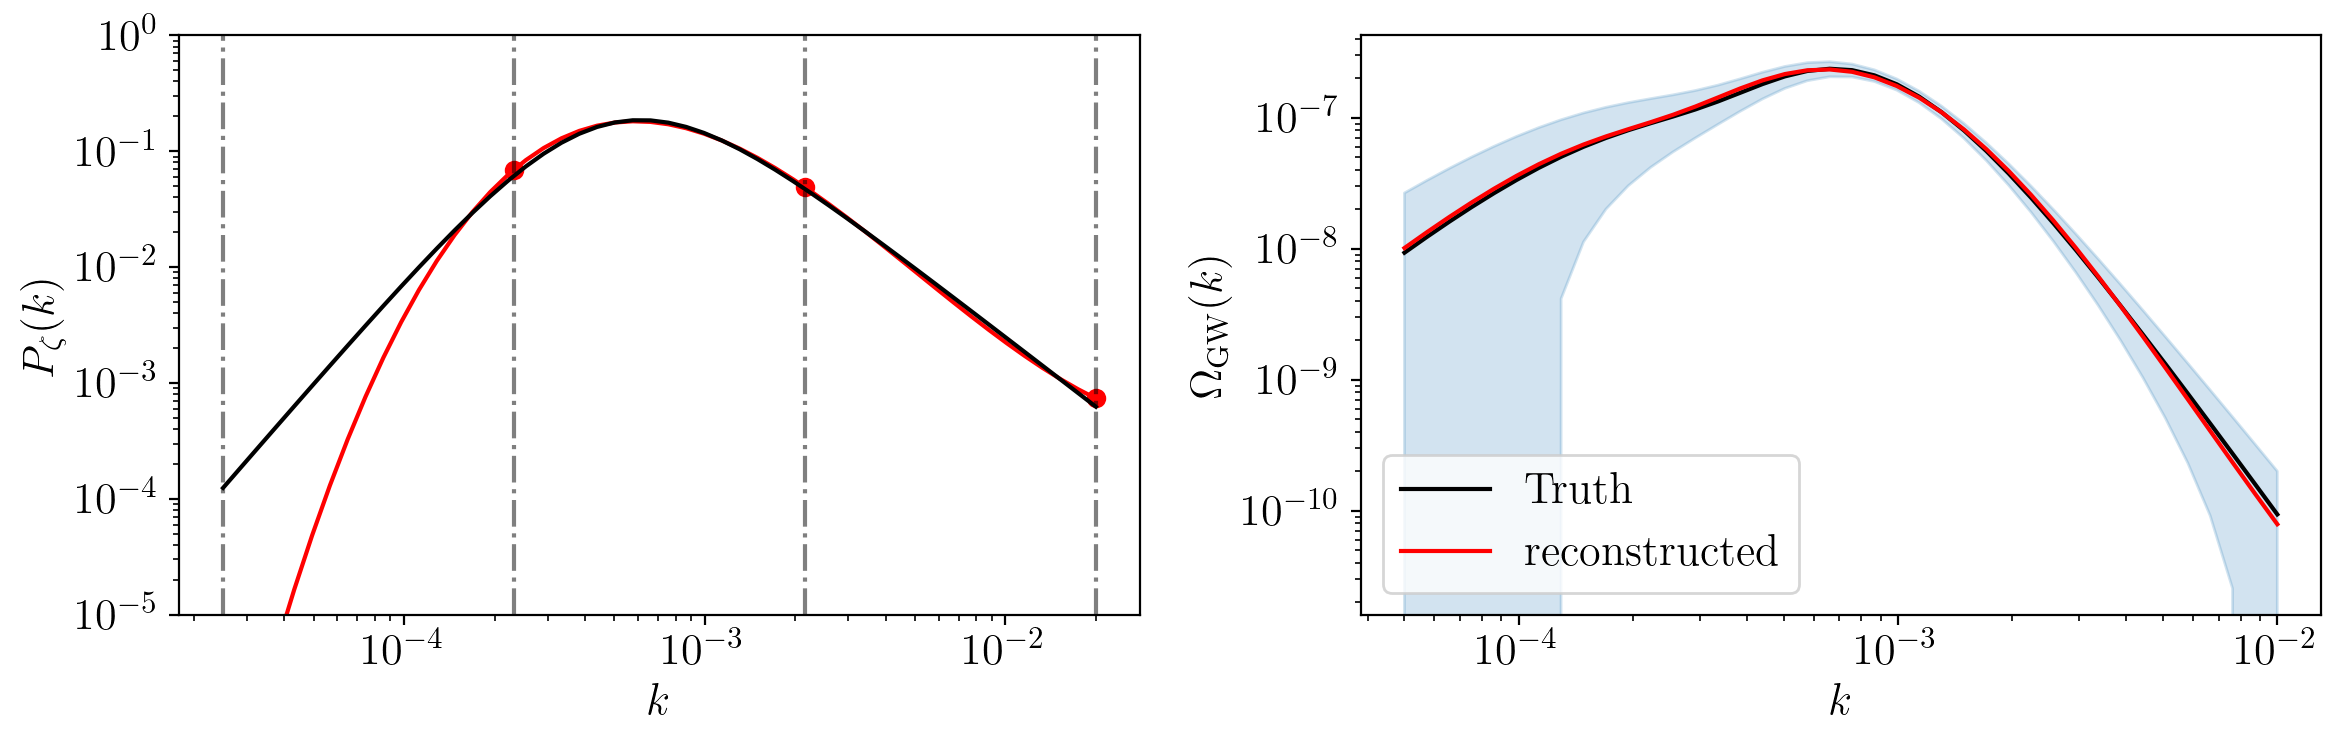

In [13]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

ax1.loglog(p_arr,pz_bf(p_arr),color='r')
ax1.loglog(p_arr,pz_amp,color='k',lw=1.5)
ax2.plot(k_arr,gwb_amp,color='k',lw=1.5,label='Truth')
ax2.loglog(k_arr,gwb_bf,color='r',label='reconstructed')
ax2.fill_between(k_arr,gwb_amp+1.96*omks_sigma,gwb_amp-1.96*omks_sigma,alpha=0.2,color='C0')
ax2.set(yscale='log',xscale='log')

ax1.set_ylabel(r'$P_{\zeta}(k)$')
ax1.set_xlabel(r'$k$')
ax1.set_ylim(1e-5,1.)
# ax2.set_ylim(1e-11,1e-6)

ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}(k)$')
ax2.set_xlabel(r'$k$')
ax2.legend()
for val in nodes:
    ax1.axvline(10**(val),color='k',ls='-.',alpha=0.5)
ax1.scatter(10**(nodes),10**(best_params),color='r')
fig.tight_layout()


#### Testing with the free nodes model

In [23]:
# Set up the free node interpolator
kmin, kmax = min(p_arr), max(p_arr)
gwb_method_kwargs = {'s': s, 't': t}
pz_model = Free_Nodes_Model(n_nodes=3,pz_kmin=kmin,pz_kmax=kmax,
                            gwb_karr=k_arr,gwb_means=gwb_amp,
                            gwb_cov=gwb_cov,gwb_method='jax',gwb_method_kwargs=gwb_method_kwargs,y_low=-5,y_high=1)

In [30]:
# run the HMC
samples, extras = pz_model.run_hmc_inference(num_warmup=512,num_samples=1024,seed=42)

sample: 100%|██████████| 1536/1536 [17:22<00:00,  1.47it/s, 63 steps of size 3.09e-02. acc. prob=0.87]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      x[0]     -4.60      0.00     -4.60     -4.60     -4.60      0.50      1.00
      x[1]     -4.01      0.25     -4.07     -4.40     -3.61      7.86      1.17
      x[2]     -3.49      0.17     -3.49     -3.79     -3.23     27.66      1.02
      x[3]     -2.50      0.29     -2.51     -2.92     -2.01     20.85      1.03
      x[4]     -1.70      0.00     -1.70     -1.70     -1.70      0.50      1.00
 x_init[0]      0.48      0.16      0.45      0.25      0.75      8.38      1.16
 x_init[1]      0.38      0.15      0.39      0.13      0.59      9.90      1.29
 x_init[2]      0.55      0.16      0.55      0.28      0.78     21.85      1.02
      y[0]     -2.94      1.48     -2.94     -4.99     -0.92      5.30      1.01
      y[1]     -2.25      0.80     -2.20     -3.48     -0.91      7.31      1.02
      y[2]     -1.02      0.31     -0.94     -1.47     -0.73     16.57      1.03
      y[3]     -1.66      0

(64, 50)


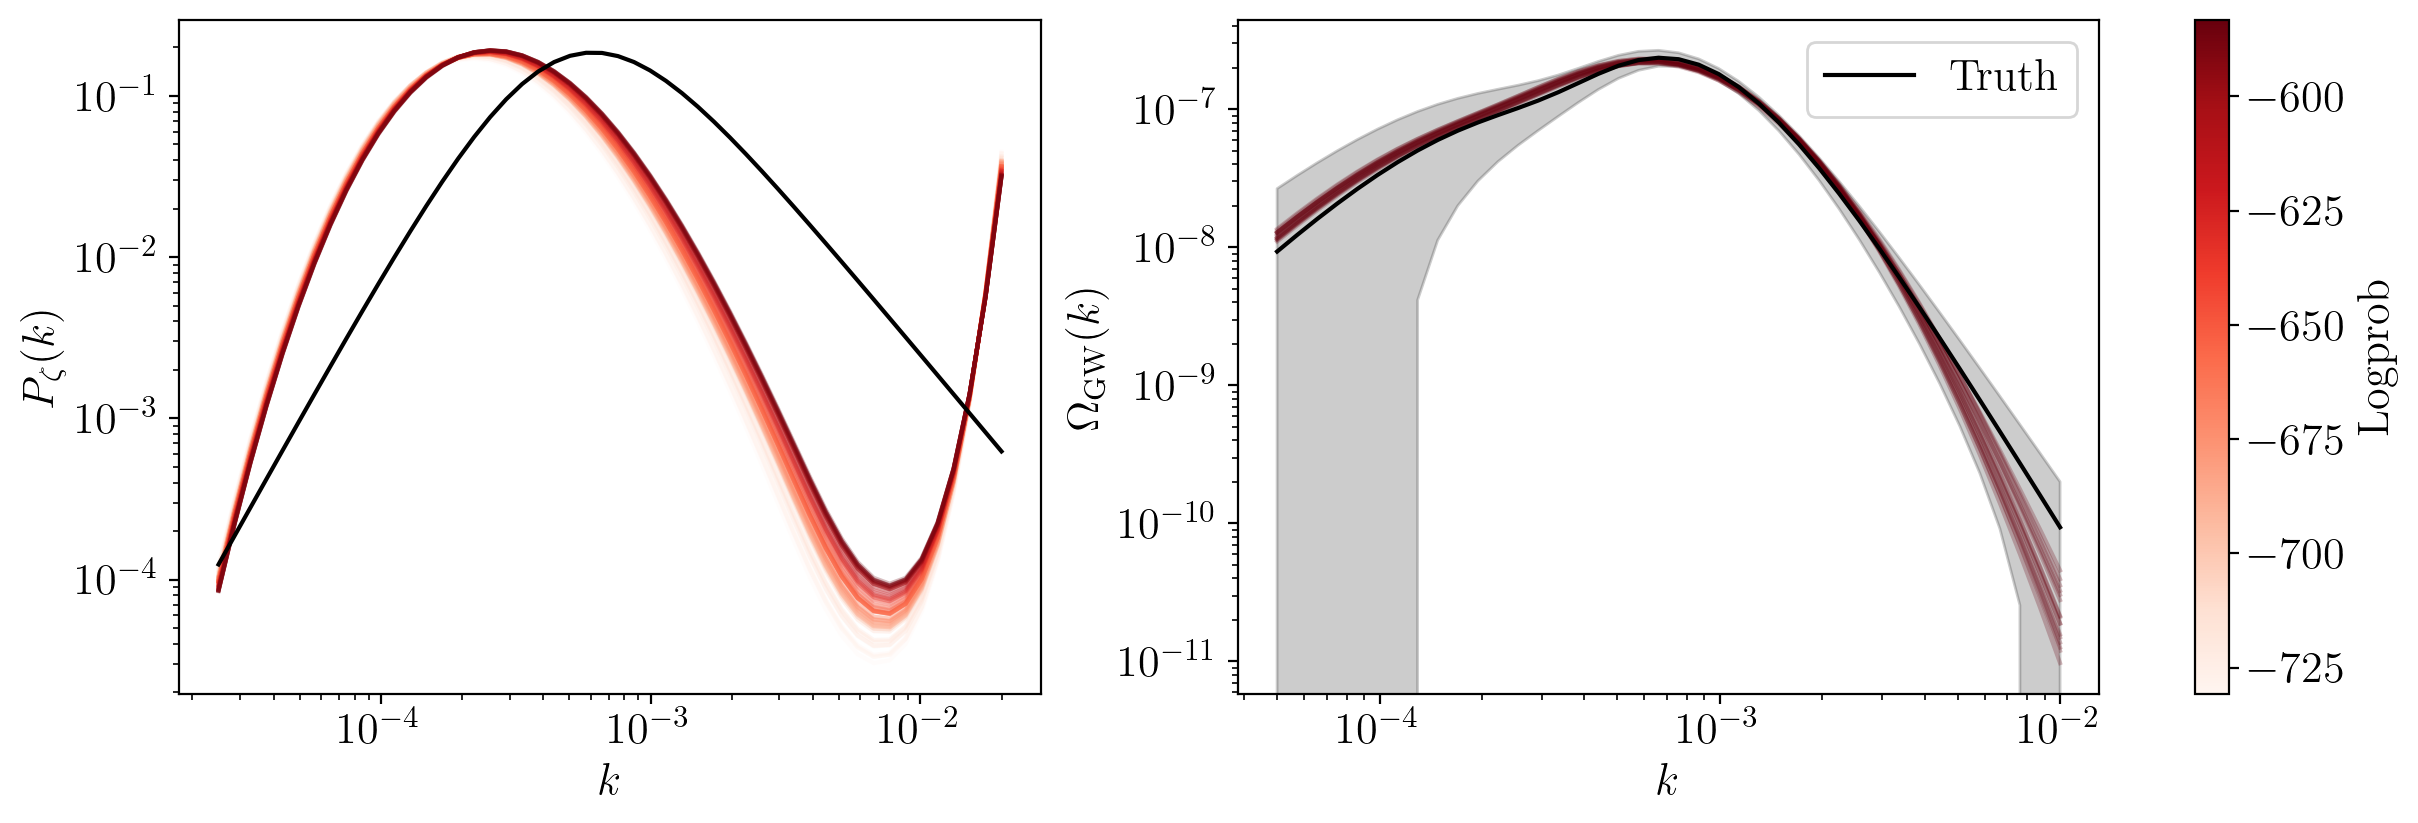

In [29]:
### Plot the MC realisations with their logprob
thinning = 16
cmap = matplotlib.colormaps['Reds']
ys = samples['y'][::thinning]
xs = samples['x'][::thinning]
lp = -extras["potential_energy"][::thinning] # PE = -negative logprob
lp_min, lp_max = np.min(lp), np.max(lp)
cols = (lp-lp_min)/(lp_max - lp_min) # normalise the logprob to a colour
norm = colors.Normalize(lp_min,lp_max)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4),layout='constrained')
ff = lambda x,y: spline_predict(x_train=x,y_train=y,x_pred=p_arr)
pz_amps = vmap(ff,)(xs,ys)
print(pz_amps.shape)
for i,pz in enumerate(pz_amps):
    ax1.loglog(p_arr,pz,alpha=0.25,color=cmap(cols[i]))
    # ax1.scatter(10**(nodes),10**(ys[i]),s=16,alpha=0.5)
for om in gwb_amps:
    ax2.loglog(k_arr,om,alpha=0.25,color=cmap(cols[i]))
ax1.loglog(p_arr,pz_amp,color='k',lw=1.5)
ax2.loglog(k_arr,gwb_amp,color='k',lw=1.5,label='Truth')

ax2.legend()
ax1.set_ylabel(r'$P_{\zeta}(k)$')
ax1.set_xlabel(r'$k$')
# ax2.set_ylim(1e-11,1e-6)
ax2.fill_between(k_arr,gwb_amp+1.96*omks_sigma,gwb_amp-1.96*omks_sigma,alpha=0.2,color='k')

ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}(k)$')
ax2.set_xlabel(r'$k$')
fig.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap),ax=[ax1,ax2],label='Logprob')

# fig.subplots_adjust(hspace=0.3)
# fig.tight_layout()